In [1]:
#instala pacotes
!pip install pulp
!pip install networkx
!pip install deepdiff


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.3 MB 23.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 576 kB/s 


In [2]:
#baixa arquivos de dados
!wget https://raw.githubusercontent.com/neimarcos/Mestrado/main/exemplo.graphml
!wget https://raw.githubusercontent.com/neimarcos/Mestrado/main/exemplo_pequeno.graphml
!wget https://raw.githubusercontent.com/neimarcos/Mestrado/main/Rnp.graphml
!wget https://raw.githubusercontent.com/neimarcos/Mestrado/main/Geant2012.graphml


--2022-11-18 00:57:08--  https://raw.githubusercontent.com/neimarcos/Mestrado/main/exemplo.graphml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14254 (14K) [text/plain]
Saving to: ‘exemplo.graphml’

exemplo.graphml     100%[===================>]  13.92K  --.-KB/s    in 0s      

2022-11-18 00:57:08 (110 MB/s) - ‘exemplo.graphml’ saved [14254/14254]

--2022-11-18 00:57:09--  https://raw.githubusercontent.com/neimarcos/Mestrado/main/exemplo_pequeno.graphml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7917 (7.7K) [text/plain]
S

In [ ]:
import copy
from pprint import pprint
import networkx as nx
import pandas as pd
import numpy as np
from pulp import *

def ClearRoutes(spf):
    """
    Clear routes, remove reverse path. We will only use it with bidirectional measurement

    ### Parameters    
    spf (dict) : dictionary of dictionaries with path[source][target]=[list of nodes in path], return from function shortest_path from networkx library

    ### Returns
        dict : routes with only one path between two host 
    """
    ###  
    routes = []
    for source in spf:
        for target, path in spf[source].items():
            if (source != target):
                reverse_path = copy.deepcopy(path)
                reverse_path.reverse()
                if reverse_path not in routes:
                    routes.append(path)
    return(routes)


def Count_Subsegment_Occurrences(routes):
    """
    Find and count how many times each subsegment occurs.
    
    ### Parameters:
    spf (dict) : routes with only one path between two host 

    ### Returns
        dict : with the subsegments and how many times they occur in the path
    """
    
    ### Clear routes, remove reverse path 
    routes_aux = routes.copy()
    index = 0
    Path_Count_Occurrences = []
    for route in routes:
        count = 0
        #print(f"Route: {route}")
        for route_aux in routes_aux:
            try:
                index = route_aux.index(route[0])
                if route == route_aux[index:index+len(route)]:
                    #pprint (route_aux)
                    count += 1
            except ValueError:
                pass
        Path_Count_Occurrences.append((route, count, len(route)))
    return (Path_Count_Occurrences)

def Nexts_Paths(pos, paths, subpaths):
    """
    Finds the next possible subpaths for composing the route

    ### Parameters:
        pos (int): current position on the route to start the scan
        route(list): route to analyze possible compositions of subpaths
        (list): possible subpaths of the route

    ### Returns:
        list:list of next possible subpaths in the composition
    """    
    Nexts = []
    if paths[pos] != paths[len(paths)-1]:
        for subpath in range(len(subpaths)):
            if paths[pos] == subpaths[subpath][0]:
                Nexts.append(subpath)
    return (Nexts)

def Compose_Subpaths(Path, SubPaths, pos = 0 , path_segment = []):
    """
    Finds all possible subpath compositions of a path    
    
    ### Parameters:
        path_segment (list): current segment of path
        rota (list): path to finds possible compositions
        subrotas (list): all possibles subpaths 
        pos (int): initial position to find, default 0
        
    ### Returns:
        list: List of all possible subpath compositions of a path
    """    
    positions = Nexts_Paths(pos, Path, SubPaths)
    compose = []
    if positions == []:
        compose.append(path_segment)
        return (compose)
    else:
        compose_path = []
    for pos in positions:
        compose_path = copy.deepcopy(path_segment)
        compose_path.append(SubPaths[pos])
        saltos = Compose_Subpaths( Path, SubPaths, Path.index(SubPaths[pos][(len(SubPaths[pos])-1)]), compose_path)
        compose.extend(saltos)
    return (compose)

def Find_Compose_Paths(path_count):
    """ 
    Finds all possible compositions for all paths
    
    ### Parameters:
        path_count (list): all paths/subpaths and how many times it repeats
    ### Returns:
        list: all possible possible combinations of subpaths for all paths
    """
    paths=tuple([k[0] for k in path_count])
    ComposePaths = []
    global Measurements_List
    global Probes_List
    for path in paths:
        if len(path) > 2:
            #pprint(f"Origem: {i}, destino: {k}, rota spf: {v} ")
            subpaths = []
            for i in range(len(path)):
                for j in range(i + 1, len(path) + 1):
                    subpath = (path[i: j])
                    if (len(subpath) > 1) and (len(subpath) < len(path)):
                        try:
                            subpaths.append(subpath)
                        except ValueError as e:
                            pprint("Subcaminho não existente")
            retorno = (Compose_Subpaths(path, subpaths))
            ComposePaths.append (retorno)
            for comp in retorno:
                Measurements_List.append(path)
                Probes_List.append(comp)
        #elif len(path) > 1:
        #    Measurements_List.append(path)
        #    Probes_List.append(path)
    return (ComposePaths)

def Compose_Route_Cost(df, rotascompostas):
    """
    Calculate cost based composition of subpaths
    
    ### Parameters:
        df (dataframe): dataframe with all paths
        rotascompostas (list): all possible possible compositon of subpaths for all paths
        
        
    """
    def encontrapeso(salto):
        df2 = df[df['path_str'].astype(str) == str(salto)]
        if df2.empty:
            reverso = list(reversed(salto))
            df2 = df[df['path_str'].astype(str) == str(reverso)]
        return (2 * (df2.iloc[0]['count']))
    global Cost_List
    
    for rotascomp in rotascompostas:
        val = 0
        for composicao in rotascomp:
            if type(composicao) is str:
                val = encontrapeso(rotascomp)
                break
            else:
                val += encontrapeso(composicao)
        Cost_List.append(val)

def extractlabel(salto):
    caminho_string = ''
    for no in salto:
        caminho_string += str(no) + '-'
    return caminho_string[:-1]


#rede = 'Geant2012.graphml'
#rede = 'Rnp.graphml'
#rede = 'exemplo.graphml'
#rede = 'exemplo_pequeno.graphml'

G = nx.read_graphml(rede)
spf = nx.shortest_path(G, weight='LinkSpeedRaw')

# Clear routes
paths = ClearRoutes (spf)

# counts how many times a subsegment/subpath occurs in the spf 
path_count = Count_Subsegment_Occurrences(paths)

df = pd.DataFrame(path_count)
df.columns = ['path', 'count', 'length']
df['path_str'] = df['path'].astype(str)

Measurements_List = []
Probes_List = []
Cost_List = []

compose_paths = Find_Compose_Paths(path_count)

Compose_Route_Cost(df, Probes_List)

MedidasSondas= {'Measurements': Measurements_List,
           'Probes': Probes_List,
           'Cost': Cost_List,
           }

dfMedidasSondas = pd.DataFrame(MedidasSondas)


lista_medicao, num_sonda_medicao = np.unique(Measurements_List, return_counts=True)

Medicoes_Pesos = []
dictMedicoes_Pesos = {}

#Medicao = [tuple(m) for m in Measurements_List]
str_medicao = []
for medicao in lista_medicao.tolist():
    str_medicao.append(extractlabel(medicao))

for idMedicao, Medicao in enumerate(Measurements_List):
    df_medicao = dfMedidasSondas[dfMedidasSondas['Measurements'].astype(str) == str(Medicao)]
    #pprint(Medicao)
    #pprint(df_medicao)
    Medicao_Peso = []
    for sonda in range (len(df_medicao)):
        Medicao_Peso.append(df_medicao.iloc[sonda]['Cost'])
    for x in range(sonda,(max(num_sonda_medicao))):
        Medicao_Peso.append(0)
    dictMedicoes_Pesos[extractlabel(Medicao)] = Medicao_Peso
    Medicoes_Pesos.append(Medicao_Peso)

Sondas = [*range(1, max(num_sonda_medicao)+1,1)]

SondasDict = LpVariable.dicts("combinacoes", (str_medicao, Sondas), 0, 1, LpInteger)

modelo_colocacao = LpProblem("Probes Placement Model", LpMaximize)
    
modelo_colocacao += (lpSum([SondasDict[m][s] * dictMedicoes_Pesos[m][s] for m in str_medicao for s in Sondas]),"Peso_total",)

for m in str_medicao:
        modelo_colocacao += (lpSum([SondasDict[m][s] for s in Sondas]) <= 1, "Max_Uma_Sonda_Por_MEdicao" + str(m))

routers = G.nodes

#max_sondas = [3,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5]     


max_sondas = {n: (len(list(nx.all_neighbors(G, n)))//2)for n in G.nodes}

#pprint(max_sondas.keys()[max_sondas.values().index(18)])


#pprint(dfMedidasSondas)
for router in routers:
    list_probes = []
    Measurement = ''
    for index, row in dfMedidasSondas.iterrows():
        if (Measurement != row['Measurements']):
            Measurement = row['Measurements']
            idprobe = 1
        else:
            idprobe += 1
        if router in Measurement:
            probes = row['Probes']
            #pprint(probes)
            for probe in probes:
                # se o probe tem inicio ou fim no router
                if (probe[0] == router) or (probe[len(probe)-1]== router):
                    list_probes.append([extractlabel(Measurement),idprobe])              
    modelo_colocacao += (lpSum([SondasDict[M][S] for M, S in list_probes]) <= max_sondas.get(router), "Max_Probes_Router" + router)    


 
modelo_colocacao.writeLP(rede.replace(".graphml", ".LP"))
modelo_colocacao.solve()
print("Status:", LpStatus[modelo_colocacao.status])
for v in modelo_colocacao.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)
print("Custo = ", value(modelo_colocacao.objective))



Status: Optimal
R_10_1_1_6_6_16_13_13_0_12_11_11_19 = 1.0
R_11_12_0_13_13_16_16_6_6_3_3_8 = 1.0
R_11_12_12_0_0_13_13_16_9_9_4 = 1.0
R_14_13_13_0_0_12_12_11 = 1.0
R_17_12_0_13_16_9_9_4 = 1.0
R_18_17_17_12_0_13_16_9_9_4 = 1.0
R_19_11_11_12_12_0_0_13_13_16_6_1_1_10 = 1.0
R_2_1_1_9 = 1.0
R_4_9_9_16_13_0_12_11 = 1.0
R_4_9_9_16_13_0_12_17_17_18 = 1.0
R_5_16_6_3_8 = 1.0
R_5_16_7 = 1.0
R_8_3_3_2 = 1.0
R_8_3_3_2_2_1 = 1.0
R_8_3_3_2_2_1_1_10 = 1.0
R_8_3_3_4_4_9 = 1.0
Custo =  2712.0


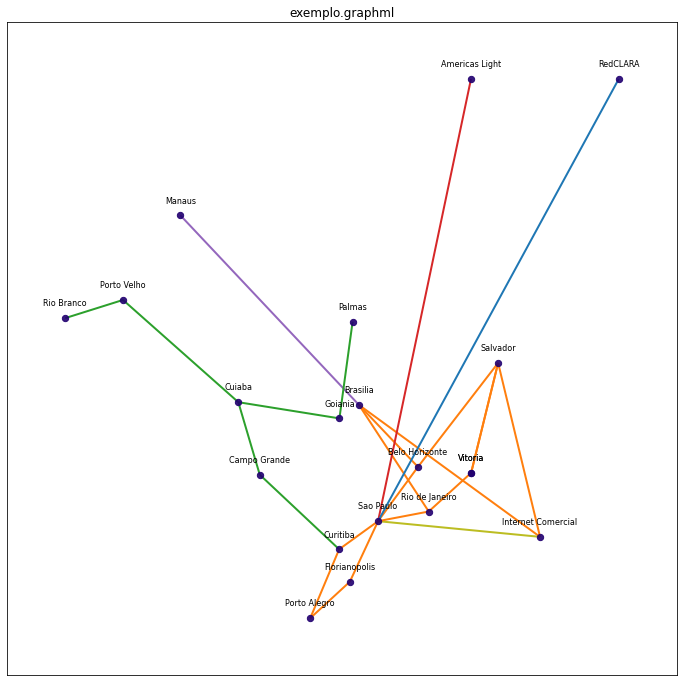

In [ ]:
import networkx as nx
from pprint import pprint
import operator
import matplotlib.pyplot as plt
import pandas as pd
from pulp import *
import copy
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Com base na posição do elemento(no) encontra posições que um elemente(no) ocorre em um lista (rotas)
# pos = posicao do elemento 
# rota =
# subrota = 
def encontraposicoes (pos,rota,subrotas):
    posicoes = []
    if rota[pos]!=rota[len(rota)-1]:
      for subrota in range(len(subrotas)):
            if rota[pos] == subrotas[subrota][0]:
                posicoes.append(subrota)
    return (posicoes)  
    
def compoe_subrotas(pos, par_rota_composta, rota, subrotas,pesos):
    posicoes = encontraposicoes(pos,rota,subrotas)
    saida = []
    if posicoes == []:
        #pprint(f'Composta: {par_rota_composta}')
        saida.append(par_rota_composta)
        return (saida)
    else:
        rota_composta = [] 
    for posicao in posicoes:
        rota_composta = copy.deepcopy(par_rota_composta)
        rota_composta.append(subrotas[posicao])
        saltos = compoe_subrotas(rota.index(subrotas[posicao][(len(subrotas[posicao])-1)]),rota_composta,rota,subrotas,pesos)
        saida.extend(saltos)
    return (saida)
 

def carregaRNP(G):
    G = nx.read_graphml('Rnp.graphml.xml')
    return(nx.shortest_path(G,weight='LinkSpeedRaw'))

def carregaExemplo(G):
    G = nx.read_graphml('exemplo.xml')
    return(nx.shortest_path(G))


# Baseado no retorno do SPF do NetworkX descobre todos os caminhos únicos
def limparotas(spf):
    MIN_LEN = 2
    chunks = list()
    for i in spf:
        for k, v in spf[i].items():  
            if (len(v) >= MIN_LEN) :
                chunks.append(v)
    return (chunks)

# Encontra o número de vezes que um combinação de rotas ocorre, idenpendete do tamnho
def ContaOcorrencias(chunks):
    chunks_aux = chunks.copy()
    index = 0
    count_sequencias=0
    caminhopeso = []
    for v in chunks:
        count = 0
        count_sequencias +=1 
        #print(f" Sequencia: {v}")
        for v_aux in chunks_aux:
            try:
                index = v_aux.index(v[0])
                if v == v_aux[index:index+len(v)]:
                    #pprint (v_aux)
                    count += 1
            except ValueError:
                pass
        #pprint(f" Total: {count}")
        caminhopeso.append((count,len(v), v))
        #pprint(f" Total de Sequências diferentes: {count_sequencias}")
    return(caminhopeso)        
        

# Organiza  e Filtra as rotas, deixando somente um sentido, pois nossas medidas são bidirecionais e também
# Filtra rota com mais de 2 soltos, pois podem ser alcaçandas através da agregação
# uma unica direção, remover os inversos , 1-> 2 = 2 -> 1

def EncontraRotasCompostas(caminhopeso):
    caminho_unidirecional = []
    caminhopeso_aux = caminhopeso.copy()
    for caminho in caminhopeso[:]:
        reverso =list(reversed(caminho[2]))
        #pprint(f"Caminho: {caminho[1]}")
        #pprint(f"Reverso: {reverso}")
        peso = caminho[0]
        for caminho_aux in caminhopeso_aux[:]:
            if caminho_aux[2] == reverso:
            #pprint(f"Tem reverso")
                caminhopeso.remove(caminho_aux)
                peso += caminho_aux[0]
        i = tuple ((peso, caminho[1], caminho[2]))
        irevese = tuple ((peso, caminho[1], reverso))
        if i not in caminho_unidirecional and irevese not in caminho_unidirecional:
            caminho_unidirecional.append(i) 
    #ordena as rotas pelo peso (número de ocorrência)
    rotas_pesos = sorted(caminho_unidirecional, key=operator.itemgetter(0))
    #Filtra rota com mais de 2 soltos, pois podem ser alcaçandas através da agregação
    #rota_compor = list(filter(lambda rota: rota[1] >= 3, rotas_pesos))
    return (rotas_pesos)

def pesorotascompostas(df, rotascompostas):
    for rotascomp in rotascompostas: 
        #print(f'Essas rotas {rotascomp}')
        #print(f'Count {len(rotascomp)}')    
        for rota in rotascomp:
            #print(f'Essa rota {rota}')
            #print(f'Count {len(rota)}')
            if len(rota) >  1 :
                custo_rota = 0;
                composicao = ''
                for salto in rota:
                    #print(f'Count {len(salto)}')
                    df2=df[df['caminho_str'].astype(str)== str(salto)]
                    val = 2 *(df2.iloc[0]['peso'])
                    composicao += extractlabel(salto) + '+'
                    #pprint(f'{label} - {val}')
                    custo_rota += val
                composicao = composicao[:-1]
                Lista_Rota.append(str(composicao))
                Lista_Custo.append(str(custo_rota))
            else:
                df2=df[df['caminho_str'].astype(str)== str(salto)]
                val = 2 *(df2.iloc[0]['peso'])
                Lista_Rota.append(str(rota))
                Lista_Custo.append(str(val))

def extractlabel(salto):
    caminho_string = ''
    for no in salto:
        caminho_string  += str(no) + '-'
    return caminho_string[:-1]



def EncontraComposicoesPosiveis(caminhopesobidirecional):
    df_caminhos = pd.DataFrame(caminhopesobidirecional)
    caminhos = tuple(df_caminhos[2])
    pesos = tuple(df_caminhos[0])
    rotascompostas = []
    for i in spf:
        for k, v in spf[i].items(): 
            if len  (v) > 2:       
                #pprint(f"Origem: {i}, destino: {k}, rota spf: {v} ")
                test_str = v
                subcaminhos = []
                pesos_subcaminhos = []
                #rotascompostas.append(v)
                for i in range(len(test_str)):
                    for j in range(i + 1, len(test_str) + 1):
                        subcaminho = (test_str[i: j]) 
                        subcaminho_reverse= list(reversed(subcaminho))
                        if len(subcaminho) > 1 and len(subcaminho) < len (test_str):
                            #pprint(subcaminho)
                            #pprint(subcaminho_reverse)
                            try :
                                if subcaminho in caminhos:
                                    pos = caminhos.index(subcaminho)
                                    #pprint(f"Subcaminho {subcaminho} na posição {pos} com peso {pesos[pos]}  " )
                                    subcaminhos.append(subcaminho)
                                    pesos_subcaminhos.append(pesos[pos])
                                else:
                                    pos = caminhos.index(subcaminho_reverse)
                                    #pprint(f"Subcaminho_reverse {subcaminho_reverse} na posição {pos} com peso {pesos[pos]}  " )
                                    subcaminhos.append(subcaminho)
                                    pesos_subcaminhos.append(pesos[pos])
                            except ValueError as e:
                                pprint("Subcaminho não existente")        
                caminhos_par = []
                #print(f'SubRotas: {subcaminhos}')
                #pprint(compoe_subrotas(0,caminhos_par))
                rotascompostas.append(compoe_subrotas(0,caminhos_par,v,subcaminhos,pesos_subcaminhos))
                #pprint(rotascompostas)
    return(rotascompostas)

def exibegrafico(G):
  node_dist_to_color = {
      1: "tab:red",
      2: "tab:orange",
      3: "tab:olive",
      4: "tab:green",
      5: "tab:blue",
      6: "tab:purple",
      7: "tab:gray",
  }

  plt.figure(rede,figsize=(12,12)) 

  Links = nx.get_edge_attributes(G,'LinkLabel').values()

  cores = []
  for key in Links:
    if (key == '20Gbps'):
      cores.append(node_dist_to_color[1])
    elif(key=='10Gbps'):
      cores.append(node_dist_to_color[2])
    elif(key=='3.5Gbps'):
      cores.append(node_dist_to_color[3])
    elif (key == '3Gbps'):
      cores.append(node_dist_to_color[4])
    elif (key == '1.45Gbps'):
      cores.append(node_dist_to_color[5])
    elif(key=='200Mbps'):
      cores.append(node_dist_to_color[6])
    elif(key=='20Mbps'):
      cores.append(node_dist_to_color[7])
  # setup Lambert Conformal basemap.
  # set resolution=None to skip processing of boundary datasets.

  label_dic = dict(list(G.nodes(data="label")))
  Latitude = (list(G.nodes(data="Latitude")))
  Longitude = (list(G.nodes(data="Longitude")))


  pos={}
  poslabel={}
  for i in range(G.number_of_nodes()):
    pos[str(i)]= [float(Longitude[i][1]), float(Latitude[i][1])]
    poslabel[str(i)]= [float(Longitude[i][1]), float(Latitude[i][1]+1)]

  nx.draw_networkx_edges(G, pos,edge_color=cores, width=2)
  nx.draw_networkx_labels(G, poslabel,label_dic,font_size=8)
  nx.draw_networkx_nodes(G, pos, node_size=40, node_color="#210070", alpha=0.9)

  plt.title(rede)


  plt.show()

#spf= carregaExemplo(G)
#spf= carregaRNP()
#pprint(spf)
    

#rede = 'Geant2012.graphml'
#rede = 'Rnp.graphml'
rede = 'exemplo.graphml'
#rede = 'exemplo_pequeno.graphml'

G = nx.read_graphml(rede)

spf = nx.shortest_path(G,weight='LinkSpeedRaw')
#pprint(spf)             

rotas=limparotas(spf)
#pprint(rotas)

caminhopeso = ContaOcorrencias(rotas)
#pprint()
df= pd.DataFrame(caminhopeso)
df.columns = ['peso', 'tamanho', 'caminho']
df['caminho_str'] = df['caminho'].astype(str)

Lista_Rota = []
Lista_Custo = []
for k, v, x in caminhopeso: 
    Lista_Rota.extend({extractlabel (x)})
    Lista_Custo.append(str(k))
    #pprint(f'{extractlabel (x)} =  {k}')

Lista_RotaSimple =  copy.deepcopy(Lista_Rota)
    
caminhopesobidirecional=EncontraRotasCompostas(caminhopeso)
#pprint(caminhopesobidirecional)

rotascompostas = EncontraComposicoesPosiveis(caminhopesobidirecional)
#pprint(rotascompostas)
          
pesorotascompostas(df, rotascompostas)    

max_sondas = [3,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5,5,4,5,6,8,2,3,6,7,3,6,3,5,1,0,1,3,2,2,3,4,1,3,1,3,2,4,2,5,3,1,2,3,5]     


#pprint(Lista_Rota) 
#pprint(Lista_Custo) 

Dic_Custo = dict(zip(Lista_Rota,[int(x) for x in Lista_Custo]))

#pprint(Dic_Custo)

# Create the 'prob' variable to contain the problem data
prob = LpProblem("Proble Problem", LpMaximize)

# 
rota_var = LpVariable.dicts("R", Lista_Rota, 0, 1, LpInteger)

# The objective function is added to 'prob' first
prob += (
    lpSum([Dic_Custo[i] * rota_var[i] for i in Lista_Rota]),"Total Cost ",
)


routers = G.nodes


    
# Maximo de sondas em um roteador
for router in routers:
    Lista_Inicio_Fim = []
    #pprint(f'Router: {router}')
    for rota in Lista_Rota:
        #pprint(rota[0:rota.find('-')])
        #pprint(rota[rota.rfind('-')+1:])
        #pprint(rota.find(router+'+'+router))
        if router == rota[0:rota.find('-')] or router == rota[rota.rfind('-')+1:] or rota.find(router+'+'+router)>0:
            #pprint (f'Rota: {rota} - Inicio: {rota[0:len(router)]} - Fim {rota[len(rota)-len(str(router)):]}')
            #pprint (f' Len Rota {len(rota)} Len do route {len(router)}')
            Lista_Inicio_Fim.append(rota)
    if Lista_Inicio_Fim:
        #pprint(Lista_Inicio_Fim)
        prob += (lpSum([rota_var[i] for i in Lista_Inicio_Fim]) <= max_sondas[int(router)], "Origem_Destino" + str(router))    
'''
for router in routers:
    Lista_Inicio_Fim = []
    pprint(f'Router: {router}')
    for rota in Lista_Rota:
        #pprint(rota[0:rota.find('-')])
        #pprint(rota[rota.rfind('-')+1:])
        #pprint(rota.find(router+'+'+router))
        if rota.find(router+'+'+router)>0:
           pprint (f'Duas sondas no router {router} na rota {rota}')
           for router_aux in routers:
                for rota_aux in Lista_Rota:
                    if rota_aux.find(router+'+'+router_aux)>0 or rota_aux.find(router_aux+'+'+router)>0 :
                        pprint (f'rota_aux {rota_aux}')
'''                 
    

# Evita medição duplicada - Rota reversa
for rota in Lista_RotaSimple:
    Inverso = []
    #if rota[0:rota.find('-')]  == rota[len(rota) - rota.find('-'):]:
    origem = rota[0:rota.find('-')]
    destino = rota[rota.rfind('-')+1:]
    #pprint (f'Rota: {rota} Origem - {origem} Destino - {destino}')
    #pprint(origem)
    for rota_aux in Lista_RotaSimple:
        origem_aux=rota_aux[0:rota_aux.find('-')]
        destino_aux=rota_aux[rota_aux.rfind('-')+1:]
        #pprint (f'Rota_aux: {rota_aux} Origem - {origem_aux} Destino - {destino_aux}')
        if origem == destino_aux and destino == origem_aux:
            #pprint (f'Rota inversa: {rota_aux}')
            #pprint (f'Rota_aux: {rota_aux} Origem - {origem_aux} Destino - {destino_aux}')
            Inverso.append(rota)
            Inverso.append(rota_aux)
    if Inverso:
        #pprint(Inverso)
        prob += (lpSum([rota_var[i] for i in Inverso]) <= 1, "RotaInversa" + str(rota))



prob.writeLP(rede.replace(".graphml", ".LP"))
prob.solve()
print("Status:", LpStatus[prob.status])
for v in prob.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)
print("Custo = ", value(prob.objective))

exibegrafico(G)